In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

In [4]:
# Only keep samples with current profiles that exceed 1 kA
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

In [5]:
# Shift center of mass of each current profile onto the origin

def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

In [6]:
# Interpolate all current profiles onto the same samples of s

limit = max(max(np.abs(s)) for s, _ in shifted)
new_s = np.linspace(-limit, limit, 100)

interpolated = [(new_s, np.interp(new_s, s, current, left=0, right=0)) for s, current in shifted]

In [8]:
# Make formfactors
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors_both = [current2formfactor(*current, grating="both") for current in filtered]
formfactors_low = [current2formfactor(*current, grating="low") for current in filtered]
# formfactors_high = [current2formfactor(*current, grating="high") for current in filtered]

## Training

In [11]:
def train(formfactors, currents):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in interpolated])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    ff_scaler = MinMaxScaler()
    X_train_scaled = ff_scaler.fit_transform(X_train)
    current_scaler = 1 / y_train.max(axis=1).mean()
    y_train_scaled = y_train * current_scaler
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y_train.shape[1], activation="relu")]
    )
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=64, validation_split=0.25, verbose=0)
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Loss (MSE)")
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.subplot(122)
    plt.title("MAE")
    plt.plot(history.history["mae"], label="Training")
    plt.plot(history.history["val_mae"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
    X_test_scaled = ff_scaler.transform(X_test)
    y_test_scaled = y_test * current_scaler
    score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)
    
    X_test_scaled = ff_scaler.transform(X_test)
    y_predict_scaled = model.predict(X_test_scaled)
    y_predict = y_predict_scaled / current_scaler
    
    samples = np.random.randint(0, len(y_predict), size=3)

    plt.figure(figsize=(21,4))
    for i, sample in enumerate(samples):
        plt.subplot(1, 3, i+1)
        plt.title(f"Sample {sample}")
        plt.plot(new_s*1e6, y_test[sample]*1e-3, ls="--", label="Ground Truth")
        plt.plot(new_s*1e6, y_predict[sample]*1e-3, label="Prediction")
        plt.xlabel("s (μm)")
        plt.ylabel("Current (kA)")
        plt.legend()
        plt.grid()
    plt.show()
    
    return model

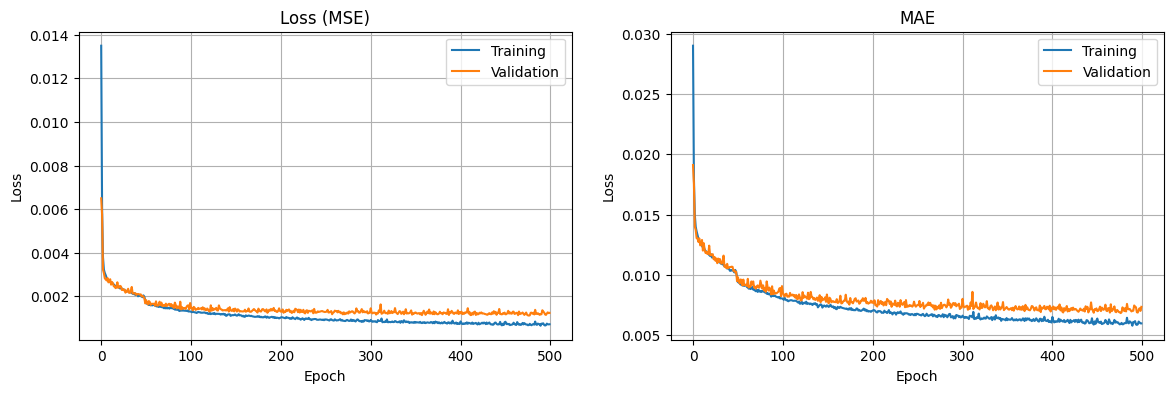

64/64 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0076


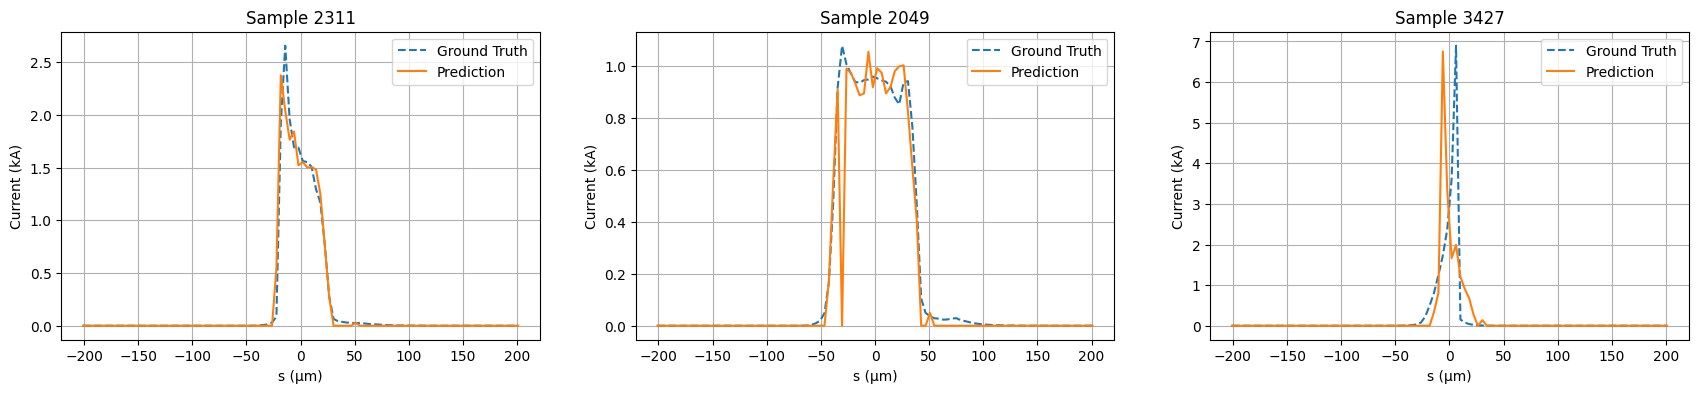

In [12]:
model_both = train(formfactors_both, interpolated)

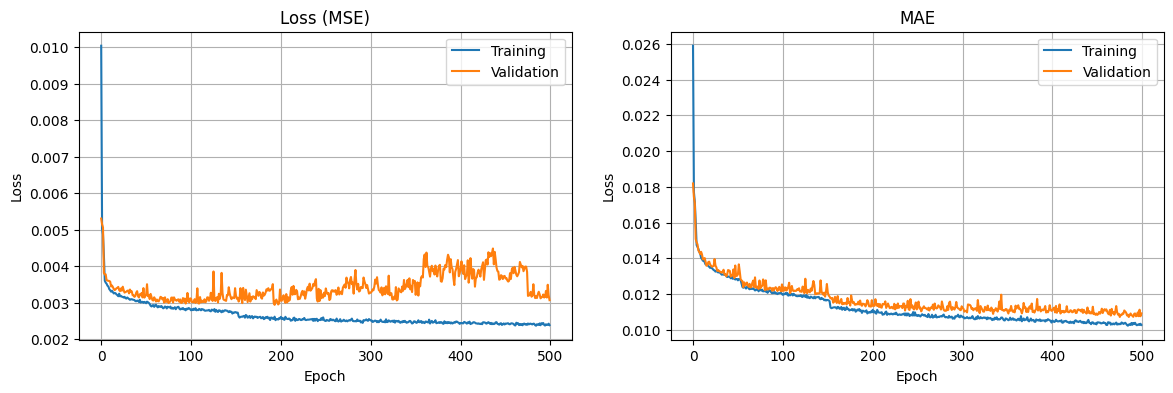

64/64 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0108


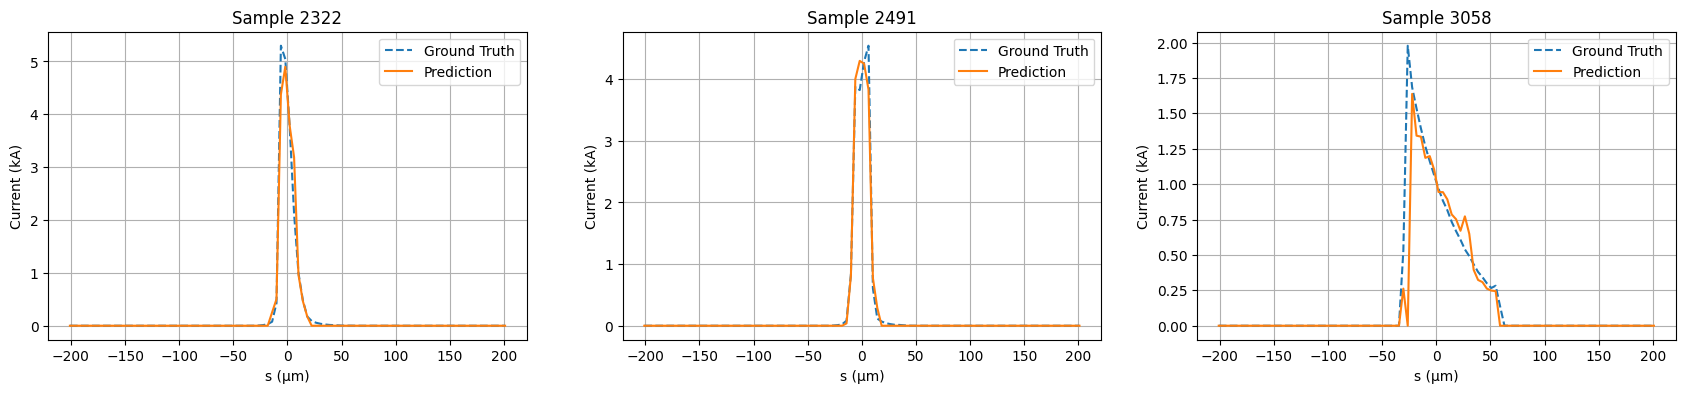

In [13]:
model_low = train(formfactors_low, interpolated)

In [16]:
model_both.save("models/model_both")
model_both.save("models/model_low")

INFO:tensorflow:Assets written to: models/model_both/assets
INFO:tensorflow:Assets written to: models/model_low/assets
